#Creating relations

In [ ]:
!unzip all.zip

Archive:  all.zip
  inflating: finishedRelations.json  
  inflating: nodes.json              


In [ ]:
import json
import random
import datetime
from dateutil import parser
import numpy
import pickle
import sklearn
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')

#logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

#type annotation
from typing import *


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!unzip nodes.zip

Archive:  nodes.zip
  inflating: nodes.json              


## Loading the data
The **nodes.json** and **finishedRelations.json** have to be loaded\

> **nodes.json** contains all the informations about the nodes such as\
the *url*, *user*, *repository*, *issueID*, *title*, *body*, *id*, *comments*\
the *title* refers to the *issue title* and the *body* to the *issue body*\
the *id* is a string following this pattern **[username]**/**[repository]**#**[issueID]**

> **finishedRelations.json** contains the relations of the issues.
This information can be accessed via *urlIssueA*, *urlIssueB*, *relation*, *dateMentioned*.  relation is hereby a int between 0 and 3.



In [ ]:
with open("nodes.json", "r") as nodes_file:
  raw_text_data = nodes_file.read()
  json_data = json.loads(raw_text_data)
print("keys in node: {}".format(", ".join(json_data[0].keys())))

with open("finishedRelations.json", "r") as relation_file:
  raw_text_data = relation_file.read()
  json_relational_data = json.loads(raw_text_data)

url_data:List[str] = list(map(lambda issue: issue["url"], json_data))
print("keys in relation: {}".format(", ".join(json_relational_data[0].keys())))
print("number of relations: {}\nnumber of nodes: {}".format(len(json_relational_data),len(json_data)))

keys in node: url, user, repository, issueID, title, body, id, comments
keys in relation: urlIssueA, urlIssueB, relation, dateMentioned
number of relations: 2004
number of nodes: 1952


## cleaning the data
In this step the relations are cleaned


In [ ]:
def mapIssueUrlToIndex(relation):
  """
  Given a relation, this function searches the indexes of both URL's involved,
  hence creates a mapping from the URL of an issue in a relation to the issue node.

  If the index hasn't been found "-1" is returned.
  """
  idxA = -1
  idxB = -1
  try:
    idxA = url_data.index(relation["urlIssueA"])
    idxB = url_data.index(relation["urlIssueB"])
  except:
    logger.debug("node not found")
  relation["urlAidx"] = idxA
  relation["urlBidx"] = idxB
  return relation

def isRelation(relation) -> bool:
  """
  This function checks if a given relation is valid, and returns True if it is the case
  """
  if relation is None or relation["relation"] is None:
    return False
  r = relation["relation"]
  if not (r == 0 or r == 1 or r == 2 or r == 3):
    logger.debug(r)
    return False
  if relation["urlIssueA"] is None or relation["urlIssueB"] is None :
    return False
  return True

def tidyRelations(relations:list) -> list:
  """
  This method cleans a relation list of all broken relations or relations, where the node couln't be found.
  It returns a list of valid relations containing the index of the nodes it is refering to.
  """
  if len(relations) == 0:
    return []
  logging.debug(f"relations before the cleaning: {len(relations)}")
  #prcondidtion - only select valid relations
  valid_relations:list = list(filter(lambda rel: isRelation(rel), relations))
  #then add the mapping to the nodes
  relations_with_mapping:list = list(map(lambda rel: mapIssueUrlToIndex(rel), valid_relations))
  #post-filter if the nodemapping couldn't be found - sort the relation out
  relations_with_valid_mapping = list(filter(lambda rel: not (rel["urlAidx"] == -1 or rel["urlBidx"] == -1), relations_with_mapping))
  logging.debug(f"relations after the cleaning: {len(relations_with_valid_mapping)}")
  return relations_with_valid_mapping


json_relational_data = tidyRelations(json_relational_data)


## Create trainingsdata
Now the relations are cleaned.\
so trainingsdata can be extracted from th relations\
trainingsdata consists of *textA*, *textB* and the *relation* in form of an array\
\
suitable_data = **List[ Tuple[ textA: str, TextB: str, relation: List[int] ] ]**

In [ ]:
with_date:int = 0     #just a interesting insight on how many dates have been found
without_date:int = 0

def getCommentsUpToSpecificDate(issue, date) -> str:
  """
  This function gathers the text from an issue up to a specific date.
  If no date is given, it returns just the issue title and body.
  """
  return_text:str = issue["title"] + "\n" + issue["body"]
  if date is None or not "comments" in issue or len(issue["comments"])==0:
    return return_text
  comments:list = issue["comments"]
  for comment in comments:
    current_date = parser.parse(comment["createdAt"])
    if current_date >= date:
      break
    return_text += "\n" + comment["body"]
  return return_text

def integerToArray(number:int) -> List[int]:
  """
  This function maps the integer given to a list envoding the number
  """
  return_array = None
  if number == 0:
    return_array = [0,0,0,0,1]  #=>
  elif number == 1:
    return_array = [0,0,0,1,0]  #<=
  elif number == 2:
    return_array = [0,0,1,0,0]  #<=>
  else:
    return_array = [0,1,0,0,0]  #dupl.
  return return_array

def createSuitableData(relation) -> Tuple[str, str, List[int]]:
  """
  This method creates data in form of (text, text, relationArray)
  from a given relation
  """
  date = None
  if "dateMentioned" in relation and not relation["dateMentioned"] ==  None:
    date = parser.parse(relation["dateMentioned"])
  global json_data
  if date is None:
    global without_date
    without_date += 1
  else:
    global with_date
    with_date += 1
  textA:str = getCommentsUpToSpecificDate(json_data[relation["urlAidx"]], date)
  textB:str = getCommentsUpToSpecificDate(json_data[relation["urlBidx"]], date)
  rel:int = int(relation["relation"])
  return textA, textB, integerToArray(rel)

logging.debug(f"with date: {with_date} vs without: {without_date}")

## Graph of graphs
A graph of the relations can be created by using the issues as nodes and the relations as edges.\

The *suitable_data_without_unrelated* above only takes the relations into account, hence **duplicate**, **related**, **from a follows b** and **from b follows a**.\
But a important relation is missing - the **not related at all**\
Because issues can be related via transitivity (or because the GitHub users of these repositories didn't annotate all relations) no issues from the same *subgraph* can be taken.\
Therefore the next part is to divide the "relation Graph" into the subgraphs. Afterwards one can randomly chose two random issues from two random (distinct) subgraphs, wich are then very likely unrelated.\
\
The image below ilustrates the issues divided into "relation" clusters or "subgraphs" (using the "view image" option, one can zoom closer and see the relations depicted using arrows)

screens(1).jpg

In [ ]:
def getAllNodes() -> Set[str]:
  """
  This function returns a set of all the issue URL's
  """
  global graph_relations
  nodes = set(map(lambda relation: relation[0], graph_relations))
  right_nodes = set(map(lambda relation: relation[1], graph_relations))
  nodes.update(right_nodes)
  return nodes

graph_relations:list = list(map(lambda relation: (relation["urlIssueA"], relation["urlIssueB"]), json_relational_data))  #all the issue urls which are in a relation
graph_nodes:Set[str] = getAllNodes()
graph_nodes_len:int = len([*graph_nodes])

def treeSearch(fringe:List[str]) -> List[str]:
  """
  This function returns a list consisting of the whole subgraph(s) the fringe node(s) are/is a part of.
  """
  global graph_nodes
  global graph_relations
  subgraph = []
  while not(len(fringe) == 0 or len(graph_relations) == 0) or len(graph_nodes) == 0:   
    start_node:str = fringe.pop()         #start node
    graph_nodes.discard(start_node)   #rempve globally
    subgraph.append(start_node)       #append to subgraph
    relations_involving_node = list(filter(lambda relation: relation[0] == start_node or relation[1]== start_node, graph_relations))      #get all edges from startnode
    graph_relations = list(filter(lambda relation: not (relation[0] == start_node or relation[1]== start_node), graph_relations))         #remove edge from relations globally
    nodes_from_relations:List[str] = list(map(lambda relation: relation[1] if relation[0] == start_node else relation[0], relations_involving_node)) #get nodes adjacent to those edges
    fringe.extend(nodes_from_relations)
  return subgraph

def createSubgraph() -> List[List[str]]:
  """
  This function creates subgraphs out of the main graph
  """
  global graph_nodes
  global graph_relations
  sub_graphs = []
  while len(graph_nodes) > 0 and len(graph_relations)>0:
    start_node:str = graph_nodes.pop()
    sub_graph:List[str] = treeSearch([start_node])
    sub_graphs.append(sub_graph)
  return sub_graphs

sub_graphs:List[List[str]] = createSubgraph()
logger.info(f"number of subgraphs: {len(sub_graphs)}")


INFO:root:number of subgraphs: 126


In [ ]:
random_number = lambda max: int(numpy.random.random()*max)
def getValidationGraphs() -> List[List[str]]:
  """
  This function cuts subgraphs out of the graph structure and returns them as a list
  """
  random_int:int = random_number(len(sub_graphs))
  valitation_graphs:list = []
  val_graph_issues:int = 0

  while val_graph_issues < int(graph_nodes_len*0.2):    #Take 20% of the graph nodes
    graph:List[str] = sub_graphs[random_int]
    valitation_graphs.append(graph)
    del sub_graphs[random_int]          #delete the item from sub_graphs
    random_int = random_number(len(sub_graphs))
    subgraph_lenghts:List[int] = list(map(lambda subgraph: len(subgraph), valitation_graphs))
    val_graph_issues = sum(subgraph_lenghts)
  return valitation_graphs

valitation_graphs:List[List[str]] = getValidationGraphs()
test_graphs:List[List[str]] = getValidationGraphs()     #changed
logger.info(f"number of subgraphs: {len(sub_graphs)}")
logger.info(f"number of validation subgraphs: {len(valitation_graphs)}")
logger.info(f"number of test subgraphs: {len(test_graphs)}")

INFO:root:number of subgraphs: 57
INFO:root:number of validation subgraphs: 38
INFO:root:number of test subgraphs: 31


In [ ]:
validation_issues:Set[str] = set([issue for graph in valitation_graphs for issue in graph])
test_issues:Set[str] = set([issue for graph in test_graphs for issue in graph])   #changed
print(json_relational_data[0].keys())

def relInSet(relation, pSet:Set[str])->bool:
  return relation["urlIssueA"] in pSet or relation["urlIssueB"] in pSet

validation_data_relation = list(filter(lambda relation: relInSet(relation, validation_issues),json_relational_data))
test_data_relation = list(filter(lambda relation: relInSet(relation, test_issues),json_relational_data))
train_data_relation = list(filter(lambda relation: not (relInSet(relation, validation_issues) or relInSet(relation, test_issues)),json_relational_data))

suitable_validation_data_without_unrelated:numpy.ndarray = numpy.array(list(map(lambda rel: createSuitableData(rel),validation_data_relation)))
suitable_test_data_without_unrelated:numpy.ndarray = numpy.array(list(map(lambda rel: createSuitableData(rel),test_data_relation)))
suitable_data_without_unrelated:numpy.ndarray = numpy.array(list(map(lambda rel: createSuitableData(rel),train_data_relation)))

print(suitable_validation_data_without_unrelated[:2])
print(len(suitable_validation_data_without_unrelated))
print(suitable_test_data_without_unrelated[:2])
print(len(suitable_test_data_without_unrelated))
print(len(suitable_data_without_unrelated))


dict_keys(['urlIssueA', 'urlIssueB', 'relation', 'dateMentioned', 'urlAidx', 'urlBidx'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


[['Volume doesn\'t sync when you delete a folder in Windows\n  - [x] I have tried with the latest version of my channel (Stable)\r\n  - [x] I have uploaded Diagnostics\r\n  - Diagnostics ID: F038DED9-684B-479E-98A8-29477AD4CF30/20200122183814\r\n\r\n### Expected behavior\r\nSync should work, if I delete a folder in Windows, ls -lsa should show me the correct result.\r\n\r\n### Actual behavior\r\nActually I have the problem when phpfpm and nginx exist in my docker-compose. If I only have the service who run my symfony the sync will work.\r\n\r\n### Information\r\n  - Is it reproducible? Yes, every time\r\n  - Is the problem new? Yes, only with 2.2.0.0\r\n  - Did the problem appear with an update? Yes, 2.2.0.0\r\n  - A reproducible case if this is a bug, Dockerfiles with reproduction inside is best.\r\n\r\n  - Windows Version: Windows 10 Version 1903 Build 18362.592\r\n  - Docker Desktop Version: 2.2.0.0\r\n  - Are you running inside a virtualized Windows e.g. on a cloud server or on a m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


After the creations of the subgraphs, random issues can be choosen between two subgraphs.

In [ ]:
number_of_issues:int = 900
number_of_validation_issues:int = int(number_of_issues*0.2)
subgraphs_len:int = len(sub_graphs)

def randomIssue(subgraph_number:int, sub_graphs:List[List[str]]) -> str:
  """
  This function returns a random Issue from a specific subgraph
  """
  subgraphs_len:int = len(sub_graphs)
  if subgraph_number > subgraphs_len:
    return
  specific_subgraph:List[str] = sub_graphs[subgraph_number]
  issue_nr:int = int(numpy.random.random()*len(specific_subgraph))
  return specific_subgraph[issue_nr]

def randomIssues(subgraph_numbers:Tuple[int], sub_graphs:List[List[str]]) -> Tuple[str]:
  """
  This function creates a tuple of two random issues
  """
  return (randomIssue(subgraph_numbers[0], sub_graphs), randomIssue(subgraph_numbers[1], sub_graphs))

def createRandomSubgraphTuple(sub_graphs:List[str], number_of_issues:int) -> List[Tuple[int,int]]:
  """
  This funcition returns a list of tuples of two random subgraphs
  """
  subgraphs_len:int = len(sub_graphs)
  random_numbers1 = numpy.random.rand(number_of_issues)
  random_numbers2 = numpy.random.rand(number_of_issues)
  #here one of all subgraphs can be choosen
  random_subgraph_left = numpy.array(list(map(lambda x: int(x*(subgraphs_len)), random_numbers1)))
  #here all subgraphs except for the one previousely can be choosen so that they are distinct
  random_subgraph_right = numpy.array(list(map(lambda x: int(x*(subgraphs_len-1)), random_numbers2)))  
  random_subgraph_tuple = zip(random_subgraph_left, random_subgraph_right)
  #if the number of the right hand side (which is one less than the total amount of subgraphs) is >= the left side, it getts +1 else stays the same
  #this guarantees, that both numbers are different, hence a different subgraph has been chosen
  random_subgraph_tuple = list(map(lambda tpl: (tpl[0], tpl[1]) if tpl[1]<tpl[0] else (tpl[0], tpl[1]+1), random_subgraph_tuple))
  logger.debug(f"random subgraph tuples: {random_subgraph_tuple[:2]}")
  return random_subgraph_tuple

def unrelatedIssueFromURLs(unrelated_issue) -> Tuple[str, str, List[int]]:
  """
  This function just puts the unrelated issue in the right format
  """
  return getIssueDataFromUrl(unrelated_issue[0]), getIssueDataFromUrl(unrelated_issue[1]), [1,0,0,0,0]  #change here the zero

def getIssueDataFromUrl(url:str) -> str:
  """
  This function returns the issue text given the url
  """
  text = None
  try:
    issue = getIssueFromUrl(url)
    text = getBodyAndCommentText(issue)
  except:
    print("Innex Not found for url: {}".format(url))
  return text

def getBodyAndCommentText(issue) -> str:
  """
  This function gets all the comments, the body and the title of a given issue
  """
  comment_bodies = ""
  ib = issue["title"] + "\n" + issue["body"]
  if ("comments" in issue and not (issue["comments"] == None or len(issue["comments"]) == 0)):
    comment_bodies = "\n".join(map(lambda c: c["body"],issue["comments"]))
  if ib == "" and issue["comments"] == "":
    raise ValueError("comments or body not found")
  return issue["body"] + "\n+" + comment_bodies

def getIssueFromUrl(url:str):
  """
  This function returns the issue given the URl
  """
  global json_data
  global url_data
  issueIdx = None
  try:
      issueIdx:int = url_data.index(url)
  except:
    raise ValueError("index not found")
  return json_data[issueIdx]

def createUnrelatedIssues(sub_graphs:List[str], number_of_issues:int) -> numpy.ndarray:
  """
  This function creates unrelated issues
  """
  random_subgraph_tuple = createRandomSubgraphTuple(sub_graphs, number_of_issues)
  #after having the subgraphs, we have to get trandom issues from within the subgraphs
  unrelated_urls = numpy.array(list(set(map(lambda x: randomIssues(x, sub_graphs), random_subgraph_tuple))))
  unrelated_issues:list = list(map(unrelatedIssueFromURLs, unrelated_urls))
  cleaned_unrelated_issues:numpy.ndarray = numpy.array(list(filter(lambda issue: not (issue[0] == None or issue[1] == None) , unrelated_issues)))
  return cleaned_unrelated_issues


unrelated_issues:numpy.ndarray = createUnrelatedIssues(sub_graphs, number_of_issues)
unrelated_validation_issues:numpy.ndarray = createUnrelatedIssues(valitation_graphs, number_of_validation_issues)
unrelated_test_issues:numpy.ndarray = createUnrelatedIssues(test_graphs, number_of_validation_issues)

suitable_data:numpy.ndarray = numpy.concatenate((suitable_data_without_unrelated, unrelated_issues), axis=0)
suitable_validation_data:numpy.ndarray = numpy.concatenate((suitable_validation_data_without_unrelated, unrelated_validation_issues), axis=0)
suitable_test_data:numpy.ndarray = numpy.concatenate((suitable_test_data_without_unrelated, unrelated_test_issues), axis=0)

logger.info(f"len unrelated issues: {len(unrelated_issues)}")
logger.info(f"len issues: {len(suitable_data)}")

logger.info(f"len unrelated val issues: {len(unrelated_validation_issues)}")
logger.info(f"len val issues: {len(suitable_validation_data)}")

logger.info(f"len unrelated test issues: {len(unrelated_test_issues)}")
logger.info(f"len test issues: {len(suitable_test_data)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
INFO:root:len unrelated issues: 895
INFO:root:len issues: 2178
INFO:root:len unrelated val issues: 180
INFO:root:len val issues: 538
INFO:root:len unrelated test issues: 179
INFO:root:len test issues: 542


## Data analysis
There are now the **suitable_data_without_unrelated** and the **unrelated_issues**, as well as the **suitable_data** list for analysing them.\
both are in the form ```[(textA, textB, relation),...]``` and have to be merged eventually, but before that, the data can be analysed.\
\
**Boxplot:**
>The boxplots are visualizing the token-length of the documents (only title + body).
The first one displays the number of tokens with outliers and the second one without.\
This will be important later for choosing the right input length

**column chart**
>The column chart visualises the token frequency of the body and title texts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(1952,)
[  5  47  10 ...  10 621   7]
34245


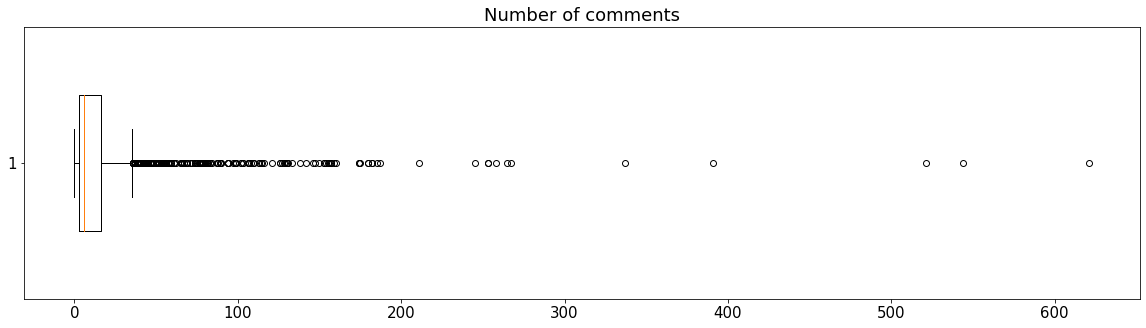

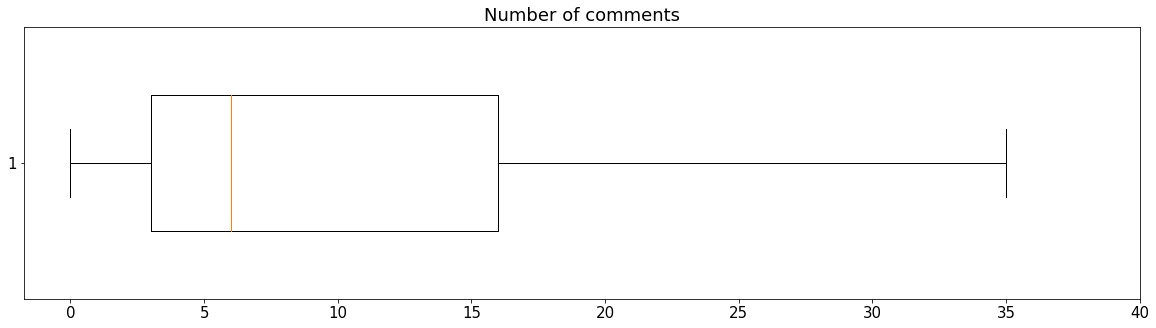

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
34245


In [ ]:
all_comments:numpy.ndarray = numpy.array(list(map(lambda node: node["comments"], json_data)))
print(all_comments.shape)
all_comments_len:numpy.ndarray = numpy.array(list(map(len, all_comments)))
print(all_comments_len)

def comment_bodies(comment_list):
  return list(map(lambda comment: comment['body'], comment_list))

comments_texts = []
for i in all_comments:
  c_bodies = comment_bodies(i)
  for c in c_bodies:
    comments_texts.append(c)

print(len(comments_texts))

plt.figure(figsize=(20, 5))
#fig1, (ax1,ax2) = plt.subplots(2, figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.title('Number of comments')
plt.boxplot(all_comments_len, vert=False, widths=.5)
plt.xticks(numpy.arange(0, all_comments_len.max()+1, 100))
plt.savefig("no_of_comments.svg", format="svg")
plt.show()

plt.figure(figsize=(20, 5))
#fig1, (ax1,ax2) = plt.subplots(2, figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.title('Number of comments')
plt.boxplot(all_comments_len, vert=False,showfliers=False, widths=.5)
plt.xticks(numpy.arange(0, all_comments_len.max()/14, 5))
plt.savefig("no_of_comments_no_outliers.svg", format="svg")
plt.show()

del all_comments_len

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents="ascii")#, stop_words="english") # without stopwords
vec = vectorizer.fit(comments_texts)
tmp = []
while len(comments_texts) >0:
  vec_res = vec.transform(comments_texts[:1000]).toarray()
  for x in vec_res:
    tmp.append(sum(x))
  comments_texts = comments_texts[1000:]
  del vec_res
  print(len(tmp))
comments_texts = numpy.array(tmp)



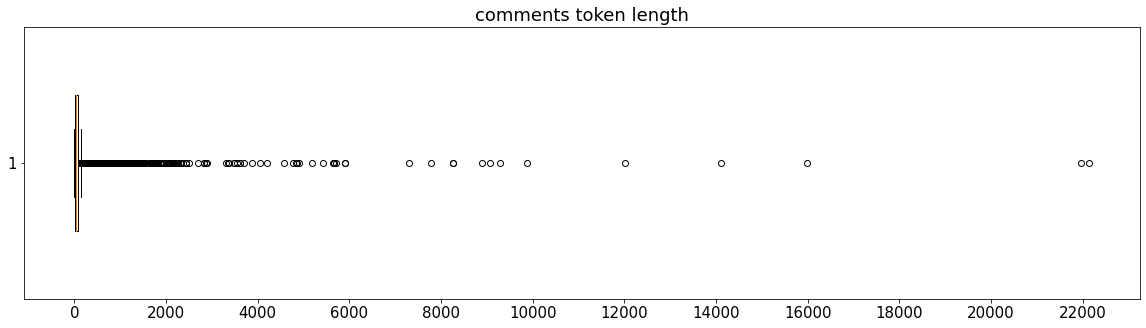

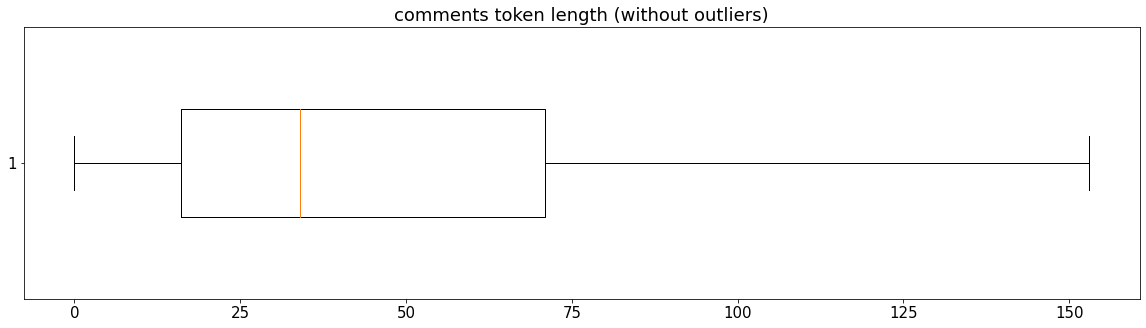

In [ ]:
#create boxplot
plt.figure(figsize=(20, 5))
#fig1, (ax1,ax2) = plt.subplots(2, figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.title('comments token length')
plt.boxplot(comments_texts, vert=False, widths=.5)
plt.xticks(numpy.arange(0, comments_texts.max(), 2000))
plt.savefig("comments_token_len.svg", format="svg")
plt.show()

#without outliers
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 15})
plt.title('comments token length (without outliers)')
plt.boxplot(comments_texts,vert=False, showfliers=False, widths=.4)
plt.xticks(numpy.arange(0, int(comments_texts.max()/140), 25))
plt.savefig("comments_token_len_no_outliers.svg", format="svg")
plt.show()

INFO:root:url of the issue with max tokens: https://github.com/kubernetes/minikube/issues/5472


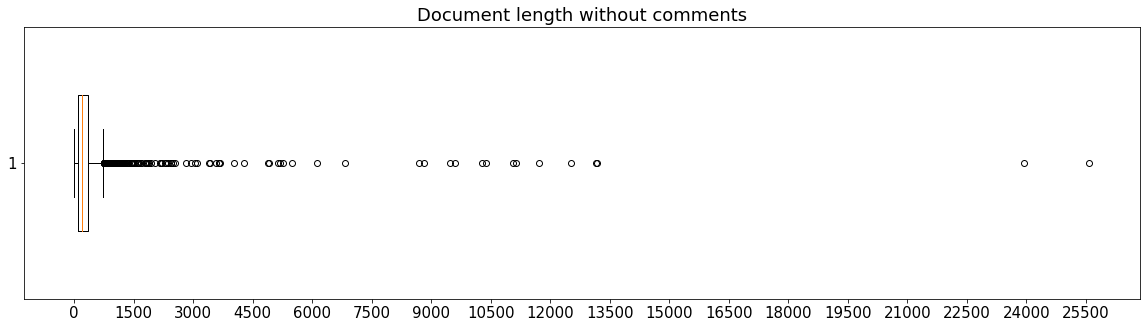

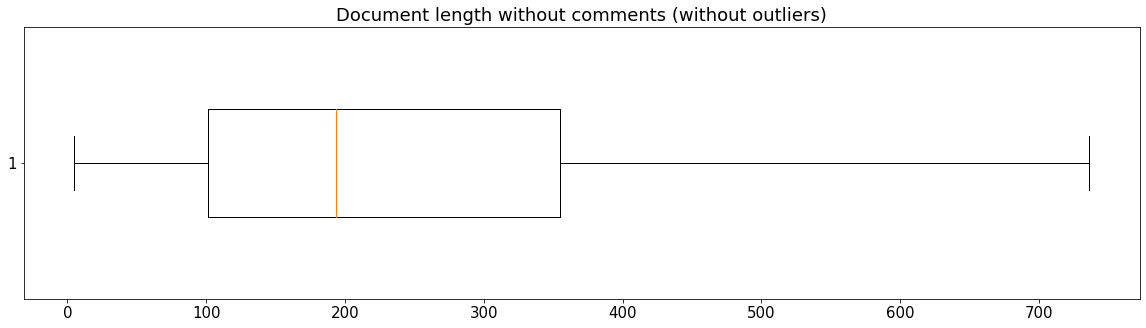

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents="ascii")#, stop_words="english") # without stopwords
texts:numpy.ndarray = numpy.array((list(map(lambda node: node["title"]+"\n"+node["body"], json_data))))
vectorized_texts = vectorizer.fit_transform(texts)
text_length:numpy.ndarray = numpy.array(list(map(lambda x: sum(x), vectorized_texts.toarray())))
logger.info("url of the issue with max tokens: {}".format(json_data[text_length.argmax()]["url"]))

#create boxplot
plt.figure(figsize=(20, 5))
#fig1, (ax1,ax2) = plt.subplots(2, figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.title('Document length without comments')
plt.boxplot(text_length, vert=False, widths=.5)
plt.xticks(numpy.arange(0, text_length.max(), 1500))
plt.savefig("doc_len_no_comments.svg", format="svg")
plt.show()

#without outliers
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 15})
plt.title('Document length without comments (without outliers)')
plt.boxplot(text_length,vert=False, showfliers=False, widths=.4)
plt.xticks(numpy.arange(0, int(text_length.max()/32), 100))
plt.savefig("doc_len_no_comments_no_outl.svg", format="svg")
plt.show()


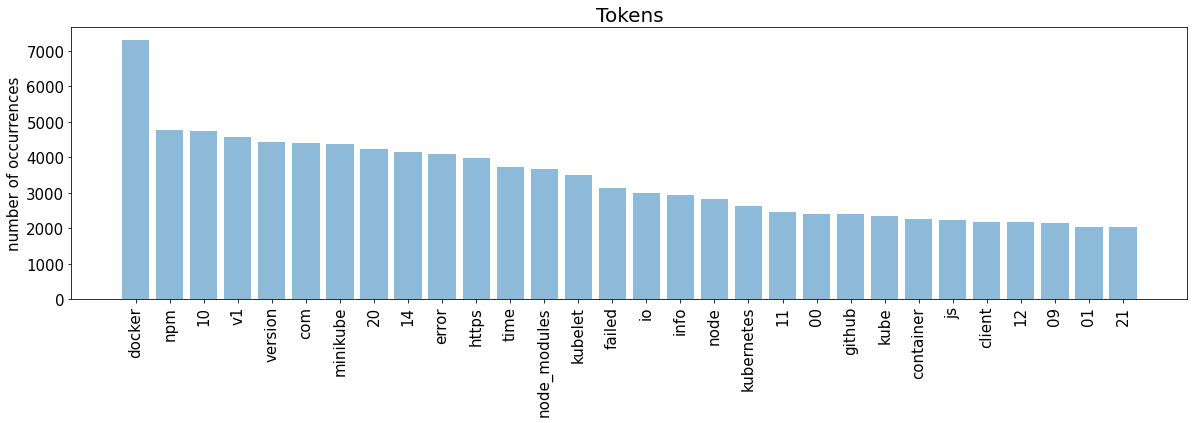

In [ ]:
#This code visualizes the token amount for the most common n tokens
vectorizer = CountVectorizer(strip_accents="ascii", stop_words="english") # without stopwords
texts:numpy.ndarray = numpy.array((list(map(lambda node: node["title"]+"\n"+node["body"], json_data))))
vectorized_texts = vectorizer.fit_transform(texts)

feature_names_and_count:List[int] = list(zip(vectorizer.get_feature_names(), sum(vectorized_texts.toarray())))
tokens_to_display:int = 30
sorted_words_amount:List[int] = sorted(feature_names_and_count, reverse=True,key=lambda x: x[1])[:tokens_to_display]

y_pos = numpy.arange(tokens_to_display)

plt.figure(figsize=(20, 5))
#plt.rcParams.update({'font.size': 20})
plt.bar(y_pos, list(map(lambda x: x[1], sorted_words_amount)), align='center', alpha=0.5)
plt.xticks(y_pos, list(map(lambda x: x[0], sorted_words_amount)), rotation=90)
plt.ylabel('number of occurrences')
plt.title('Tokens', fontsize=20)
plt.savefig("nr_words_no_token.svg", format="svg")
plt.show()

[899 420 759  41 424]


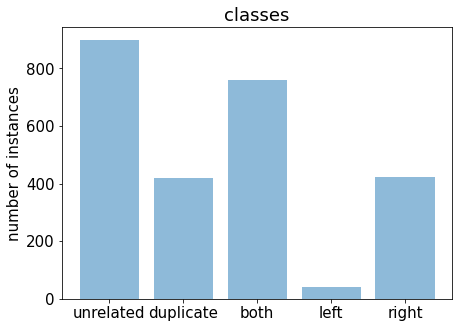

In [ ]:
#number of classes
#TODO words per class

suitable_data_sum = sum(numpy.array(list(map(lambda x: numpy.array(x), suitable_data[:,2]))))
print(suitable_data_sum)

plt.subplots(figsize=(7, 5))
plt.bar(numpy.arange(5), suitable_data_sum, align='center', alpha=0.5)  #change 4 to 5
plt.xticks(numpy.arange(5), numpy.array(["unrelated","duplicate","both","left","right"]))#"duplicate",
plt.ylabel('number of instances')
plt.title('classes')
plt.savefig("nr_classes.svg", format="svg")
plt.show()


## create training and test data
First the issues of the classes are sorted out.\
After that, relations can be exchanged between the classes.\
>For example "from a follows b" (=>) can be also "b was created by a" (<=)
by just swapping issue a and b\

This shuffeling step is necessary to generate more data, as well as to improve the siamese network architecture, because it should be "symetrical".\
Furthermore the issue classes are than cutted down to the min amount each class has, such that each class has the same aount of issues (this removes bias from the architecture)

In [ ]:
def append_issue_reversed(data:numpy.ndarray, issue_class:int, class_to_reverse:numpy.ndarray = None, reversed_class:list = None)->numpy.ndarray:
  """
  This function appends the reversed issue onto itself.
  If the function to be reversed and the original function are not the same, a reveresed_class list (the class) and a class_to_reverese int has to be provided.
  It returns an array.
  """
  filtered_data = numpy.array(list(filter(lambda issue: issue[2][issue_class] == 1, data)))
  if len(filtered_data) == 0:
    return numpy.array([])
  finished_data:numpy.ndarray = numpy.ndarray([])
  data_reversed:numpy.ndarray = numpy.ndarray([])
  if not reversed_class == None and not class_to_reverse == None:
    reverse_issue_input:numpy.ndarray = lambda issue: numpy.array([issue[1], issue[0], reversed_class])
    filtered_data2 = numpy.array(list(filter(lambda issue: issue[2][class_to_reverse] == 1, data)))
    data_reversed:numpy.ndarray = numpy.array(list(map(reverse_issue_input, filtered_data)))
    finished_data = numpy.concatenate((filtered_data2, data_reversed), axis=0)
  else:
    reverse_issue_input:numpy.ndarray = lambda issue: numpy.array([issue[1], issue[0], issue[2]])
    data_reversed:numpy.ndarray = numpy.array(list(map(reverse_issue_input, filtered_data)))
    finished_data = numpy.concatenate((filtered_data, data_reversed), axis=0)
  return finished_data


#The "new" data is appended onto the existing one
unrel_data = append_issue_reversed(suitable_data, 0)
dupl_data = append_issue_reversed(suitable_data, 1)
both_data = append_issue_reversed(suitable_data, 2)
left_data = append_issue_reversed(suitable_data, 3,4, [0,0,0,0,1])
right_data = append_issue_reversed(suitable_data, 4,3, [0,0,0,1,0])
#------------------ for val ------------------
unrel_val_data = append_issue_reversed(suitable_validation_data, 0)
dupl_val_data = append_issue_reversed(suitable_validation_data, 1)
both_val_data = append_issue_reversed(suitable_validation_data, 2)
left_val_data = append_issue_reversed(suitable_validation_data, 3,4, [0,0,0,0,1])
right_val_data = append_issue_reversed(suitable_validation_data, 4,3, [0,0,0,1,0])
#------------------ for test ------------------
unrel_test_data = append_issue_reversed(suitable_test_data, 0)
dupl_test_data = append_issue_reversed(suitable_test_data, 1)
both_test_data = append_issue_reversed(suitable_test_data, 2)
left_test_data = append_issue_reversed(suitable_test_data, 3,4, [0,0,0,0,1])
right_test_data = append_issue_reversed(suitable_test_data, 4,3, [0,0,0,1,0])


def shuffleAndChopArray(array:numpy.ndarray, chopNr:int)->numpy.ndarray:
  """
  This array shuffles the array and crops it.
  """
  return shuffleArray(array)[:chopNr]

def shuffleArray(array:numpy.ndarray)->numpy.ndarray:
  """
  This function shuffles an given array.
  """
  indexes:numpy.ndarray = numpy.arange(array.shape[0])
  random.shuffle(indexes)
  return array[indexes]

  
min_amount_of_issues:int = min(len(unrel_data), len(both_data), len(right_data), len(dupl_data),len(left_data))
min_amount_of_val_issues:int = min(len(unrel_val_data), len(both_val_data), len(right_val_data), len(dupl_val_data),len(left_val_data))
min_amount_of_test_issues:int = min(len(unrel_test_data), len(both_test_data), len(right_test_data), len(dupl_test_data),len(left_test_data))

shuffled_unrel:numpy.ndarray = shuffleAndChopArray(unrel_data, min_amount_of_issues)
shuffled_dupl:numpy.ndarray = shuffleAndChopArray(dupl_data, min_amount_of_issues)
shuffled_both:numpy.ndarray = shuffleAndChopArray(both_data, min_amount_of_issues)
shuffled_left:numpy.ndarray = shuffleAndChopArray(left_data, min_amount_of_issues)
shuffled_right:numpy.ndarray = shuffleAndChopArray(right_data, min_amount_of_issues)

shuffled_unrel_val:numpy.ndarray = shuffleAndChopArray(unrel_val_data, min_amount_of_val_issues)
shuffled_dupl_val:numpy.ndarray = shuffleAndChopArray(dupl_val_data, min_amount_of_val_issues)
shuffled_both_val:numpy.ndarray = shuffleAndChopArray(both_val_data, min_amount_of_val_issues)
shuffled_left_val:numpy.ndarray = shuffleAndChopArray(left_val_data, min_amount_of_val_issues)
shuffled_right_val:numpy.ndarray = shuffleAndChopArray(right_val_data, min_amount_of_val_issues)

shuffled_unrel_test:numpy.ndarray = shuffleAndChopArray(unrel_test_data, min_amount_of_test_issues)
shuffled_dupl_test:numpy.ndarray = shuffleAndChopArray(dupl_test_data, min_amount_of_test_issues)
shuffled_both_test:numpy.ndarray = shuffleAndChopArray(both_test_data, min_amount_of_test_issues)
shuffled_left_test:numpy.ndarray = shuffleAndChopArray(left_test_data, min_amount_of_test_issues)
shuffled_right_test:numpy.ndarray = shuffleAndChopArray(right_test_data, min_amount_of_test_issues)

print(f"min-amount of issues in classes: {min_amount_of_issues}")
print(f"min-amount of issues in classes: {min_amount_of_val_issues}")
print(f"min-amount of issues in classes: {min_amount_of_test_issues}")

weighted_data:numpy.ndarray = numpy.concatenate((shuffled_unrel, shuffled_dupl, shuffled_both, shuffled_left, shuffled_right))
weighted_data_shuffled:numpy.ndarray = shuffleArray(weighted_data)

weighted_val_data:numpy.ndarray = numpy.concatenate((shuffled_unrel_val, shuffled_dupl_val, shuffled_both_val, shuffled_left_val, shuffled_right_val))
weighted_val_data_shuffled:numpy.ndarray = shuffleArray(weighted_val_data)

weighted_test_data:numpy.ndarray = numpy.concatenate((shuffled_unrel_test, shuffled_dupl_test, shuffled_both_test, shuffled_left_test, shuffled_right_test))
weighted_test_data_shuffled:numpy.ndarray = shuffleArray(weighted_test_data)

print(sum(list(map(lambda x: numpy.array(x), weighted_data_shuffled[:,2]))))
print(sum(list(map(lambda x: numpy.array(x), weighted_val_data_shuffled[:,2]))))
print(sum(list(map(lambda x: numpy.array(x), weighted_test_data_shuffled[:,2]))))

# split data in train and test data and shuffle the data
#X = weighted_data_shuffled[:,:2]
#y = weighted_data_shuffled[:,2]
#test_dev_data = weighted_val_data_shuffled

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=15)

#data_both = X_train
#X_train_flatted = data_both.flatten()

#X_train_list: List[numpy.ndarray] = [X_train[:,0],X_train[:,1]]# list of numpy.ndarray[str]
#X_test_list: List[numpy.ndarray] = [X_test[:,0],X_test[:,1]]# list of numpy.ndarray[str]
#Y:numpy.ndarray = numpy.array([numpy.array(tmp) for tmp in y_train])   #numpy.ndarray of lists -> !!!list[list[int]] -> !!! list[ndarray[int]] -> array[array[int]] geht
#Y_test:numpy.ndarray = numpy.array([numpy.array(tmp) for tmp in y_test])   #numpy.ndarray of lists -> !!!list[list[int]] -> !!! list[ndarray[int]] -> array[array[int]] geht

#X_train_df = pd.DataFrame(X_train,columns=['IssueA', 'IssueB'])
#X_test_df = pd.DataFrame(X_test,columns=['IssueA', 'IssueB'])
X_train = pd.DataFrame(weighted_data_shuffled[:,:2], columns=['IssueA', 'IssueB'])
y_train = weighted_data_shuffled[:,2]
X_test = pd.DataFrame(weighted_test_data_shuffled[:,:2], columns=['IssueA', 'IssueB'])
y_test = weighted_test_data_shuffled[:,2]
X_val = pd.DataFrame(weighted_val_data_shuffled[:,:2], columns=['IssueA', 'IssueB'])
y_val = weighted_val_data_shuffled[:,2]


min-amount of issues in classes: 238
min-amount of issues in classes: 134
min-amount of issues in classes: 176
[238 238 238 238 238]
[134 134 134 134 134]
[176 176 176 176 176]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


y_train_sum : |[238 238 238 238 238]|=1190	y_val_sum : |[134 134 134 134 134]|=670	y_test_sum : |[176 176 176 176 176]|=880


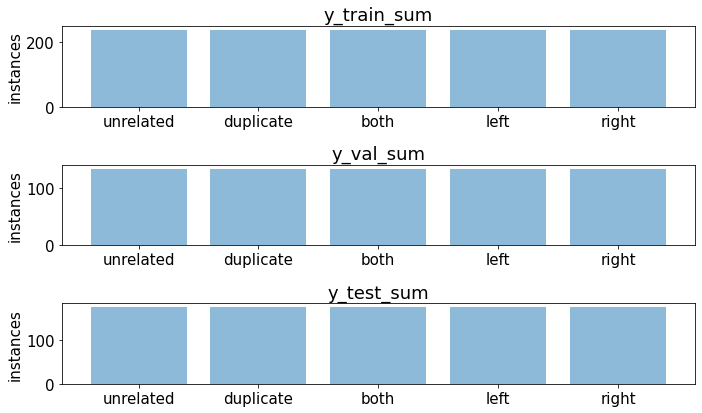

In [ ]:
y_train_sum = sum(numpy.array(list(map(lambda x: numpy.array(x), y_train))))
y_val_sum = sum(numpy.array(list(map(lambda x: numpy.array(x), y_val))))
y_test_sum = sum(numpy.array(list(map(lambda x: numpy.array(x), y_test))))

print(f"y_train_sum : |{y_train_sum}|={sum(y_train_sum)}\ty_val_sum : |{y_val_sum}|={sum(y_val_sum)}\ty_test_sum : |{y_test_sum}|={sum(y_test_sum)}")

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,6))
ax1.bar(numpy.arange(5), y_train_sum, align='center', alpha=0.5)  #change 4 to 5
ax1.set_xticks(numpy.arange(5))#"duplicate",
ax1.set_xticklabels(numpy.array(["unrelated","duplicate","both","left","right"]))
ax1.set_ylabel('instances')
ax1.set_title('y_train_sum')

ax2.bar(numpy.arange(5), y_val_sum, align='center', alpha=0.5)  #change 4 to 5
ax2.set_xticks(numpy.arange(5))#"duplicate",
ax2.set_xticklabels(numpy.array(["unrelated","duplicate","both","left","right"]))
ax2.set_ylabel('instances')
ax2.set_title('y_val_sum')

ax3.bar(numpy.arange(5), y_test_sum, align='center', alpha=0.5)  #change 4 to 5
ax3.set_xticks(numpy.arange(5))#"duplicate",
ax3.set_xticklabels(numpy.array(["unrelated","duplicate","both","left","right"]))
ax3.set_ylabel('instances')
ax3.set_title('y_test_sum')

fig.tight_layout()
plt.savefig("class_distribution.svg", format="svg")
plt.show()


##Save the data in a CSV file
The data is saved in a CSV file to save time by reloading the file instead of computing all the data all over again.

In [ ]:
#numpy.savez("y_values", Y, Y_test)
numpy.save("y_train", y_train, allow_pickle=True)
numpy.save("y_val", y_val, allow_pickle=True)
numpy.save("y_test", y_test, allow_pickle=True)

X_train.to_csv('X_train.csv', index = True)
X_test.to_csv('X_test.csv', index = True)
X_val.to_csv("X_val.csv", index = True)

ERROR:root:An error occurred while downloading files


In [ ]:
try:
  from google.colab import files
  files.download('y_train.npy')
  files.download('y_val.npy')
  files.download('y_test.npy')
  files.download('X_train.csv')
  files.download('X_test.csv')
  files.download('X_val.csv')
except Exception:
  logger.error("An error occurred while downloading files")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>